In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan.data.data import load_hires_constants, make_dataset_consistent, filter_by_lat_lon
from dsrnngan.evaluation.plots import lake_feature

In [45]:
lat_range_list = list(np.arange(-11.95, 15.05, 0.1))
lon_range_list = list(np.arange(25.05, 51.35, 0.1))

special_areas = {'Lake Victoria': {'lat_range': [-3.05,0.95], 'lon_range': [31.55, 34.55], 'abbrv': 'LV'},
                 'Somalia': {'lat_range': [-1.05,4.05], 'lon_range': [41.65, 47.05],  'abbrv': 'S'},
                 'Coast': {'lat_range': [-10.5,-1.05], 'lon_range': [37.75, 41.5],  'abbrv': 'C'},
                 'West EA Rift': {'lat_range': [-4.70,0.30], 'lon_range': [27.85,31.3],  'abbrv': 'WEAR'},
                 'East EA Rift': {'lat_range': [-3.15, 1.55], 'lon_range': [34.75,37.55],  'abbrv': 'EEAR'},
                 'NW Ethiopian Highlands': {'lat_range': [6.10, 14.15], 'lon_range': [34.60, 40.30],  'abbrv': 'EH'}}

for k, v in special_areas.items():
    lat_vals = [lt for lt in lat_range_list if v['lat_range'][0] <= lt <= v['lat_range'][1]]
    lon_vals = [ln for ln in lon_range_list if v['lon_range'][0] <= ln <= v['lon_range'][1]]
    
    if lat_vals and lon_vals:
        special_areas[k]['lat_index_range'] = [lat_range_list.index(lt) for lt in lat_vals]
        special_areas[k]['lon_index_range'] = [lon_range_list.index(ln) for ln in lon_vals]


In [41]:
oro_ds = xr.load_dataset('/bp1/geog-tropical/users/uz22147/east_africa_data/constants/h_HRES_EAfrica.nc')
oro_ds = filter_by_lat_lon(oro_ds, lon_range=lon_range_list, lat_range=lat_range_list)
oro_ds = make_dataset_consistent(oro_ds)
h_vals = oro_ds['h'].values
h_vals[h_vals < 5] = 5.0


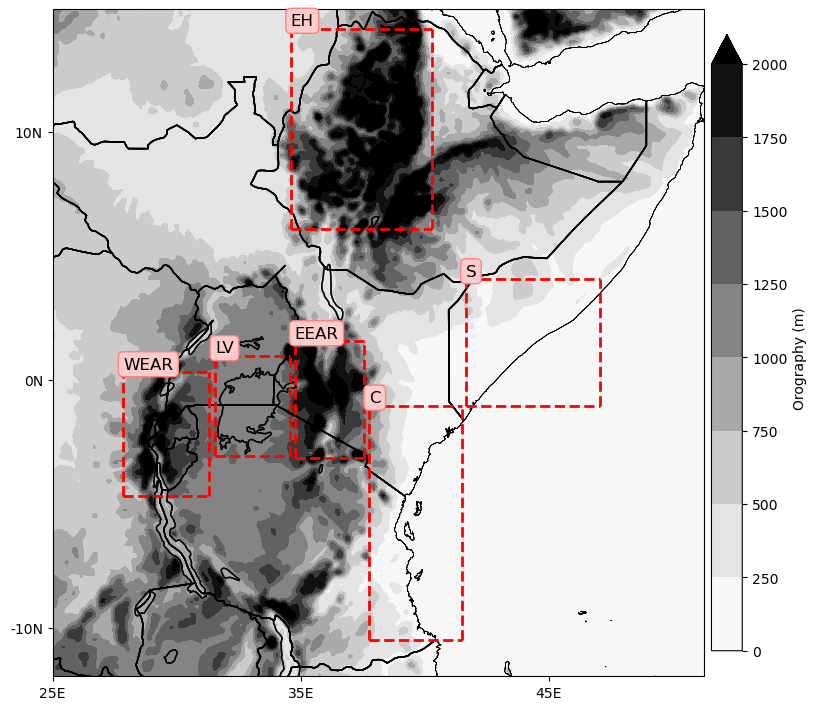

In [55]:
from matplotlib import gridspec
# fig = plt.figure(constrained_layout=True, figsize=(12, 10))
# gs = gridspec.GridSpec(1, 2, figure=fig, 
#                         width_ratios=[1, 0.05],
#                         wspace=0.005)    
# ax = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())
fig, ax = plt.subplots(1,1, subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(10,10))
hlevels = levels=[0] + list(np.arange(250, 2250, 250))
for k, sa_dict in special_areas.items():
    im = ax.contourf(lon_range_list, lat_range_list, h_vals[0,:,:], transform=ccrs.PlateCarree(), cmap='Greys', 
                levels=hlevels, extend='max')#
    ax.coastlines(resolution='10m', color='black', linewidth=0.4)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(lake_feature, alpha=0.4)
    ln_rng, lt_rng = sa_dict['lon_range'], sa_dict['lat_range']

    ax.plot([ln_rng[0], ln_rng[0]], [lt_rng[0], lt_rng[1]], color='r', linestyle='--', linewidth=2,transform=ccrs.PlateCarree())
    ax.plot([ln_rng[1], ln_rng[1]], [lt_rng[0], lt_rng[1]], color='r', linestyle='--', linewidth=2,transform=ccrs.PlateCarree())
    ax.plot([ln_rng[0], ln_rng[1]], [lt_rng[0], lt_rng[0]], color='r', linestyle='--', linewidth=2,transform=ccrs.PlateCarree())
    ax.plot([ln_rng[0], ln_rng[1]], [lt_rng[1], lt_rng[1]], color='r', linestyle='--', linewidth=2,transform=ccrs.PlateCarree(), label=k)
    ax.text(ln_rng[0], lt_rng[1] + 0.15, sa_dict['abbrv'], fontsize=12, color='k', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))
# cbar_ax = fig.add_subplot(gs[:,-1])
# cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', shrink = 0.1, aspect=2)
cbar = plt.colorbar(im,values=hlevels,pad=0.01, shrink = 0.8)
cbar.set_label("Orography (m)", loc='center')

lon_ticks = np.arange(25, 50,10)
lat_ticks = np.arange(-10, 15,10)
ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)
ax.set_xticklabels([f'{ln}E' for ln in lon_ticks])
ax.set_yticklabels([f"{lt}{'N' if lt >0 else 'N'}" for lt in lat_ticks])

plt.show()